In [1]:
import time
import numpy as np
import pandas as pd
import re

import xgboost as xgb
from xgboost.callback import _get_callback_context
from sklearn.datasets import make_classification

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 14

In [2]:
# reset_learning_rate(learning_rate) [https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/callback.py]
def reset_parameters(param_name, param_values):
    """Reset paramter values 
    Parameters
    ----------
    param_values: list or function
        List of parameter values for each boosting round
        or a customized function that calculates eta in terms of
        current number of round and the total number of boosting round (e.g. yields
        learning rate decay)
        - list l: eta = l[boosting round]
        - function f: eta = f(boosting round, num_boost_round)
    Returns
    -------
    callback : function
        The requested callback function.
    """
    def get_param_value(i, n, param_values):
        """helper providing the learning rate"""
        if isinstance(param_values, (list, np.ndarray)):
            if len(param_values) != n:
                raise ValueError("Length of list 'param_values' has to equal 'num_boost_round'.")
            new_param_value = param_values[i]
        else:
            new_param_value = param_values(i, n)
        return new_param_value

    def callback(env):
        """internal function"""
        context = _get_callback_context(env)

        if context == 'train':
            bst, i, n = env.model, env.iteration, env.end_iteration
            bst.set_param(param_name, get_param_value(i, n, param_values))
        elif context == 'cv':
            i, n = env.iteration, env.end_iteration
            for cvpack in env.cvfolds:
                bst = cvpack.bst
                bst.set_param(param_name, get_param_value(i, n, param_values))

    callback.before_iteration = True
    return callback

def get_leaf_values(tree_str):
    # To find 'leaf=0.123\n'
    prog=re.compile(r"(?<=leaf\=)(.+)\n")
    result = [float(rval) for rval in prog.findall(tree_str)]
    return np.array(result)

def get_all_leaves(bst):
    dmp = bst.get_dump()
    return [get_leaf_values(tree) for tree in dmp]

def experiment(X_train, y_train, X_valid, y_valid,
               n_rounds, params_xgb,
               param_name=None, params_values=None, lowest_score=0.0001):
    if param_name is None:
        callbacks = None
    else:
        callbacks = [reset_parameters(param_name, param_values)]
    xgmat_train = xgb.DMatrix(X_train, label=y_train)
    xgmat_valid = xgb.DMatrix(X_valid, label=y_valid)
    watchlist = [(xgmat_train, 'train'), (xgmat_valid, 'valid')]
    evals_result = {}
    t0 = time.time()
    bst = xgb.train(params_xgb, xgmat_train, n_rounds, watchlist,
                    callbacks=callbacks,
                    early_stopping_rounds=50,
                    evals_result=evals_result, verbose_eval=False)

    ntree = len(evals_result['valid']['logloss'])
    df_train_scores = pd.DataFrame({'train_loss':evals_result['train']['logloss']},
                                    index=pd.Index(range(1, ntree+1), name='Boosting iteration'))

    df_valid_scores = pd.DataFrame({'valid_loss':evals_result['valid']['logloss']},
                                    index=pd.Index(range(1, ntree+1), name='Boosting iteration'))

    leaves_lst = get_all_leaves(bst)[:ntree]
    df_leaf_cnts = pd.DataFrame({'leaf_cnts':[len(leaves) for leaves in leaves_lst]},
                                index=pd.Index(range(1, ntree+1), name='Boosting iteration'))
    df_w_L2 = pd.DataFrame({'w_L2':[np.sqrt(np.sum(leaves**2)) for leaves in leaves_lst]},
                           index=pd.Index(range(1, ntree+1), name='Boosting iteration'))
    sc_best = evals_result['valid']['logloss'][bst.best_iteration]
    print("valid_loss:%.4f, ntree:%d, %.1fs" % \
          (sc_best,
           bst.best_ntree_limit,
           (time.time() - t0)))
    fig, axes = plt.subplots(3, sharex=True, figsize=(13,9))
    #df_train_scores.plot(ax=ax[0], logy=True)
    (df_valid_scores - sc_best + lowest_score).plot(ax=axes[0], logy=True)
    df_leaf_cnts.plot(ax=axes[1])
    df_w_L2.plot(ax=axes[2])
    for ax in axes:
        #print(ax.get_xlim())
        ax.axvline(x=100, ymin=0, ymax=0.5, color='red')
        ax.axvline(x=bst.best_ntree_limit, ymin=0.25, ymax=0.5, color='blue')

In [3]:
n_train = 10 ** 6
n_valid = n_train // 4
n_all = n_train + n_valid

n_classes = 2
n_clusters_per_class = 8
n_features = 32
n_informative = n_redundant = n_features // 4

In [4]:
X, y = make_classification(n_samples=n_all,
                           n_classes=n_classes,
                           n_features=n_features,
                           n_informative=n_informative,
                           n_redundant=n_redundant,
                           n_clusters_per_class=n_clusters_per_class,
                           shuffle=True,
                           random_state=987)

In [5]:
X_train = X[:n_train]
y_train = y[:n_train]
X_valid = X[n_train:]
y_valid = y[n_train:]

In [6]:
params_xgb = {'objective'       : 'binary:logistic',
              'eval_metric'     : 'logloss',
              'eta'             : 0.1,  #default=0.3
              'max_depth'       : 20,  #default=6
              'lambda'          : 1,  #default
              'min_child_weight': 1, #default
              'silent'          : True,
              }
n_rounds = 1000

valid_loss:0.1643, ntree:172, 784.8s


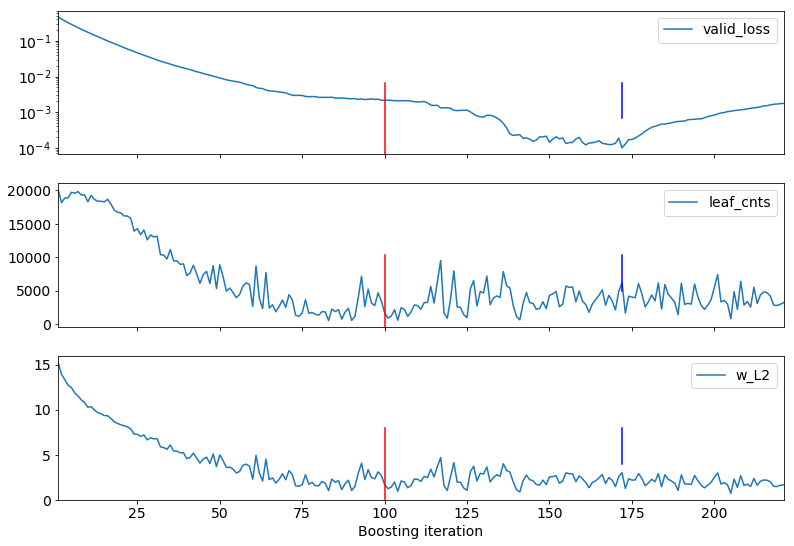

In [7]:
experiment(X_train, y_train, X_valid, y_valid, n_rounds,
           params_xgb)

valid_loss:0.1634, ntree:175, 785.4s


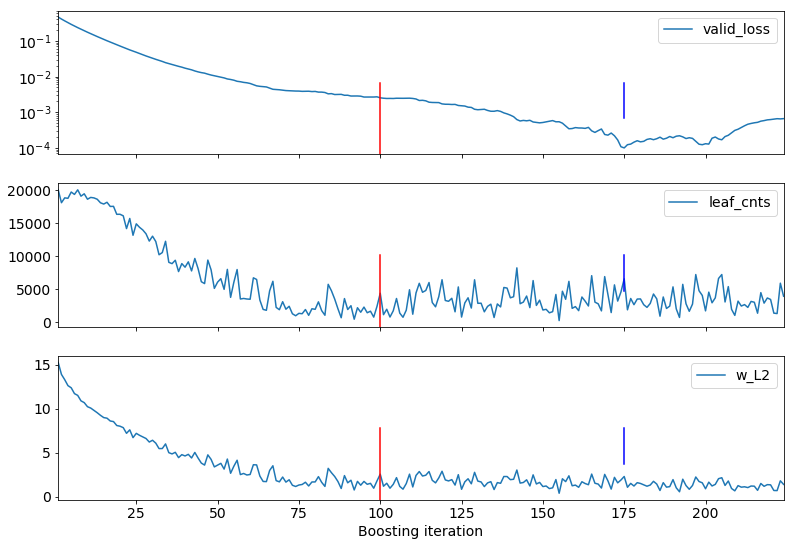

In [8]:
param_name = 'lambda'
param_values = np.linspace(1, 10, n_rounds)
experiment(X_train, y_train, X_valid, y_valid, n_rounds,
           params_xgb, param_name, param_values)

valid_loss:0.1628, ntree:153, 783.1s


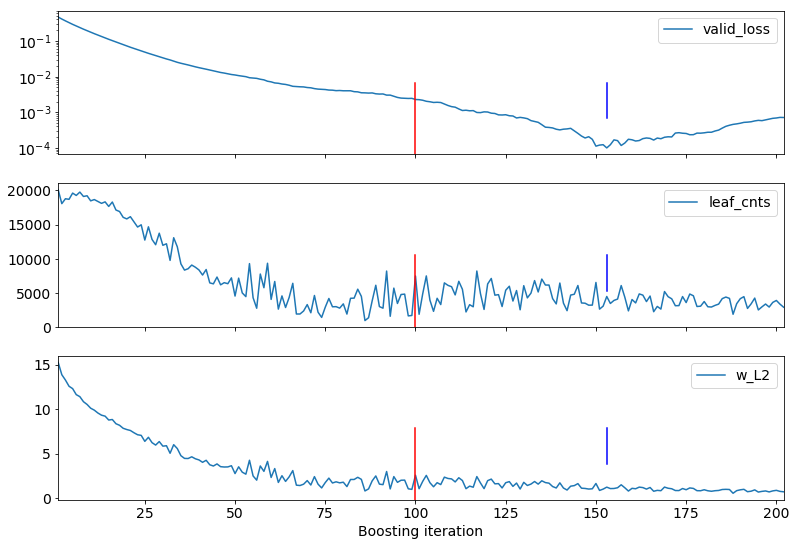

In [9]:
param_name = 'alpha'
param_values = np.linspace(0, 10, n_rounds)
experiment(X_train, y_train, X_valid, y_valid, n_rounds,
           params_xgb, param_name, param_values)

valid_loss:0.1640, ntree:202, 801.8s


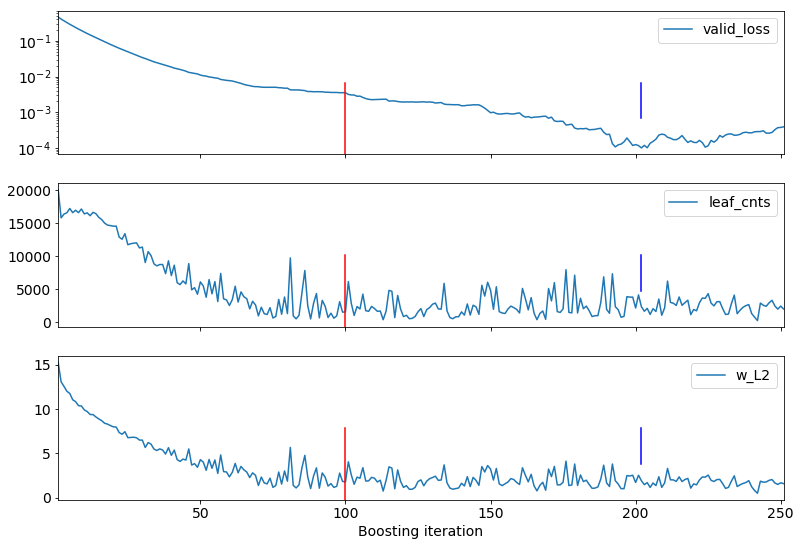

In [10]:
param_name = 'max_depth'
param_values = np.linspace(20, 10, n_rounds).astype(int)
experiment(X_train, y_train, X_valid, y_valid, n_rounds,
           params_xgb, param_name, param_values)

valid_loss:0.1591, ntree:222, 5211.1s


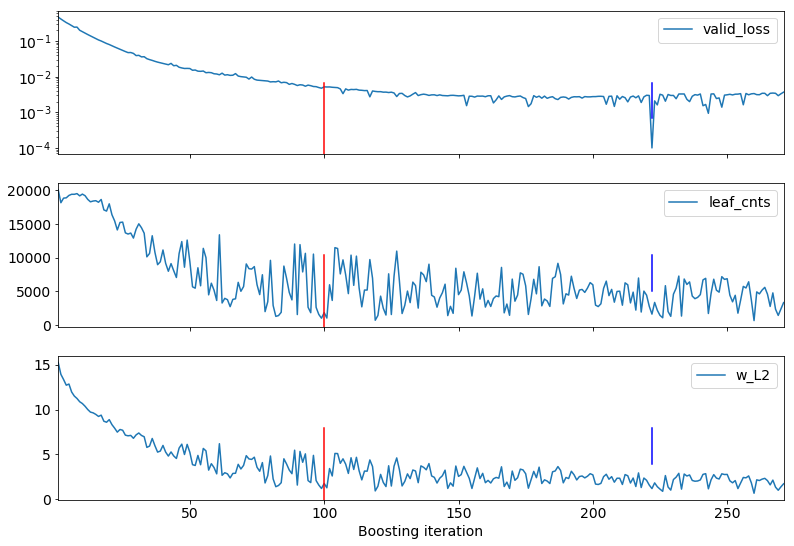

In [11]:
params_xgb.update({'booster':'dart',
                   'rate_drop':0.01,
                  })
experiment(X_train, y_train, X_valid, y_valid, n_rounds,
           params_xgb)